# Clipping Raster Data

### Introduction
In this training, we’re going to clip the raster data to the shapefile boundary, and then plot it with Python. Some of the material is taken from this [blog post](https://waterprogramming.wordpress.com/2014/10/03/python-clip-raster-data-with-a-shapefile/)

Data required
1. Raster file : The file is downloaded from this [data source](https://www.worldclim.org/data/worldclim21.html) for the historical data. The variable selected is precipitation for the month of August.      
2. Shape file : We shall use the red river basin shapefile to clip the global precipitaion data for the basin that is also used for plotting in [this tutorial](docs\FigureLibrary\SpatialPlotting\MakingWatershedMaps.ipynb)

#### Plotting Raster File 

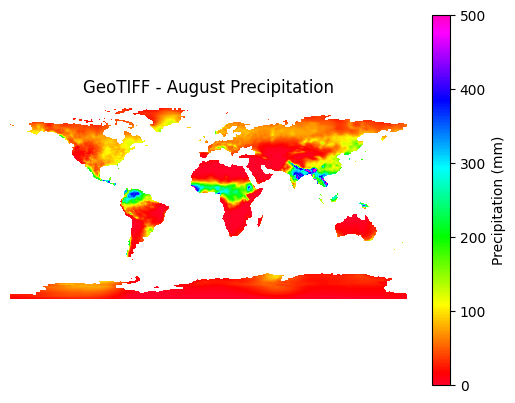

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open the TIFF file and plot
tiff_path = 'SupportingFiles/wc2.1_10m_prec_08.tif'
with rasterio.open(tiff_path) as src:
    data = src.read(1)  # read first band
    data = np.ma.masked_equal(data, src.nodata)
    plt.imshow(data, cmap='gist_rainbow', vmin=0, vmax=500)
    plt.colorbar(label='Precipitation (mm)')
    plt.title('GeoTIFF - August Precipitation')
    plt.axis('off')  # Hide axes
    plt.show()

To clip the above raster based on the Red River basin shapefile, the following code is used. See [this tutorial](docs\FigureLibrary\SpatialPlotting\MakingWatershedMaps.ipynb) for details on teh basin shapefile.

#### Clip Raster File using Shape file 

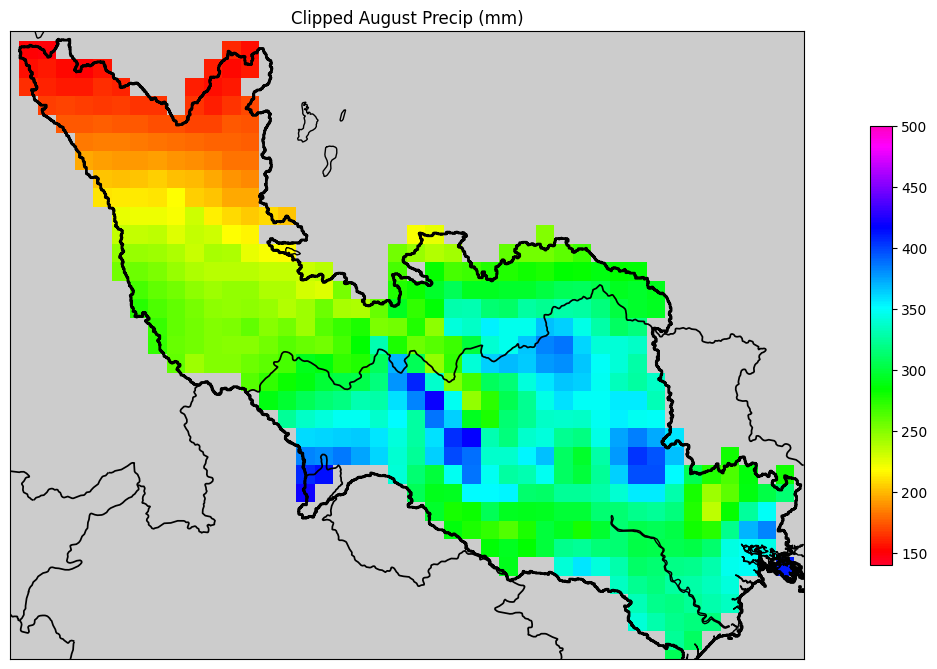

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()
fig.set_size_inches([17.05,8.15])
ax = fig.add_subplot(111)

# Load shapefile
shape_path = 'SupportingFiles/RedRiverBasin_WGS1984.shp'
gdf = gpd.read_file(shape_path)

# Open and clip raster
raster_path = "SupportingFiles/wc2.1_10m_prec_Aug.tif"
with rasterio.open(raster_path) as src:
    # Reproject shapefile to match raster CRS
    gdf = gdf.to_crs(src.crs)

    # Mask raster using geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# Prepare for plotting
data = out_image[0]
data = np.ma.masked_where(data == src.nodata, data)

xres = out_transform[0]
yres = -out_transform[4]  # yres is negative in rasterio
xmin = out_transform[2]
ymax = out_transform[5]
xmax = xmin + (xres * data.shape[1])
ymin = ymax - (yres * data.shape[0])

x, y = np.mgrid[xmin:xmax:xres, ymax:ymin:-yres]

# Set up Basemap
m = Basemap(llcrnrlat=y.min(), urcrnrlat=y.max(), llcrnrlon=x.min(), urcrnrlon=x.max(), resolution='h')
x_map, y_map = m(x, y)

# Plot
cmap = plt.cm.gist_rainbow
cmap.set_under('1.0')
cmap.set_bad('0.8')

im = m.pcolormesh(x_map, y_map, data.T, cmap=cmap, vmin=140, vmax=500)

# plot Red River basin
m.readshapefile('SupportingFiles/RedRiverBasin_WGS1984', 'Basin', drawbounds=False)#read shapefile
patches = []
for info, shape in zip(m.Basin_info, m.Basin):
    if info['OBJECTID'] == 1: # attribute in attribute table of shapefile
        patches.append(Polygon(np.array(shape), closed=True))
ax.add_collection(PatchCollection(patches, facecolor='none', edgecolor='black', alpha=1, linewidth=2)) #add collection to axis

m.drawcoastlines()
m.drawstates()
m.arcgisimage(service='World_Shaded_Relief')
# m.drawrivers(color='dodgerblue',linewidth=1.0,zorder=1)
m.drawcountries(color='k',linewidth=1.25)

cb = plt.colorbar(im, orientation='vertical', fraction=0.10, shrink=0.7)
plt.title('Clipped August Precip (mm)')
plt.show()

Figure generated above presents the precipitation for the month of August in the Red river basin. These plots help visualize and analyze data specific to the study area of focus. 